In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as T

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader

## Import Dataset

In [21]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(0.5, 0.5)
]) 

trainset = torchvision.datasets.FashionMNIST(root="../../datasets/FMNIST", train=True, download=True, transform=transform)
testset  = torchvision.datasets.FashionMNIST(root="../../datasets/FMNIST", train=False, download=True, transform=transform)
# 10000 observations in testset, divide into two for dev and test parts of the training
rand_ind = np.random.permutation(testset.data.shape[0])
devset = Subset(testset, rand_ind[:5000])
testset = Subset(testset, rand_ind[5000:])

train_loader = DataLoader(trainset, batch_size=32, drop_last=True, shuffle=True)
dev_loader   = DataLoader(devset,   batch_size=len(devset))
test_loader  = DataLoader(testset,  batch_size=len(testset))

In [29]:
np.unique(trainset.classes)

array(['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal',
       'Shirt', 'Sneaker', 'T-shirt/top', 'Trouser'], dtype='<U11')

## See some example images

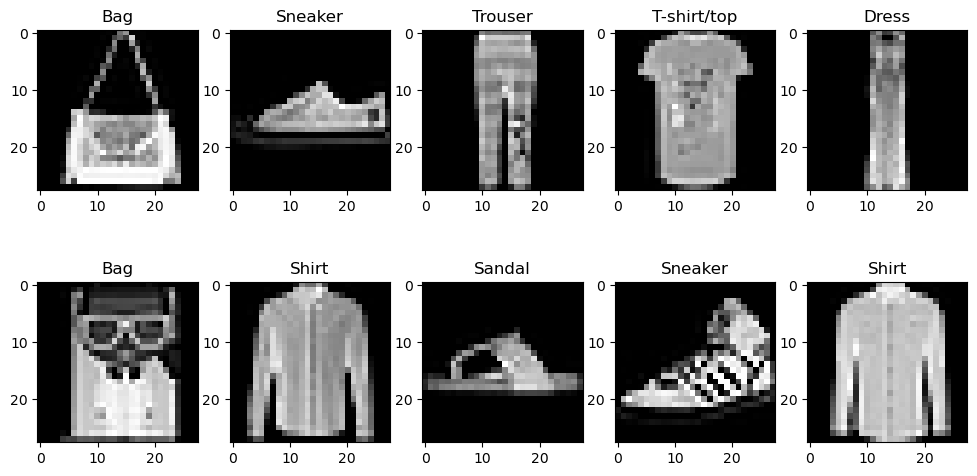

In [27]:
fig, axs = plt.subplots(2,5, figsize=[12,6])
rand_idx = np.random.choice(trainset.data.shape[0], size=10)

for i in range(5):
    axs[0,i].imshow(
        (trainset.data[rand_idx[i]].view(-1, 28, 28).permute(1,2,0).detach())/2 + 0.5,
        cmap='gray'
    )
    axs[0,i].set_title(trainset.classes[trainset.targets[rand_idx[i]]])

    axs[1,i].imshow(
        (trainset.data[rand_idx[5+i]].view(-1, 28, 28).permute(1,2,0).detach())/2 + 0.5,
        cmap='gray'
    )
    axs[1,i].set_title(trainset.classes[trainset.targets[rand_idx[5+i]]])

plt.show()

# Create CNN class

In [30]:
class FMNIST_model(nn.Module):
    def __init__(self, conv_layer_units = [16, 32, 64], printtoggle=False):
        super().__init__()

        self.print = printtoggle
        
        # conv layer 1
        self.conv1  = nn.Conv2d(1,conv_layer_units[0], kernel_size=3, stride=1, padding=1)
        self.bnorm1 = nn.BatchNorm2d(conv_layer_units[0])
        # output size = ((28 + 2*1 - 3)/1 + 1) / 2 = 14
        
        # conv layer 2
        self.conv2  = nn.Conv2d(conv_layer_units[0], conv_layer_units[1], kernel_size=3, stride=1, padding=1)
        self.bnorm2 = nn.BatchNorm2d(conv_layer_units[1])
        # output size = ((14 + 2*1 - 3)/1 + 1) / 2 = 7
        
        # conv layer 3
        self.conv3  = nn.Conv2d(conv_layer_units[1], conv_layer_units[2], kernel_size=3, stride=1, padding=1)
        self.bnorm3 = nn.BatchNorm2d(conv_layer_units[2])
        # output size = ((7 + 2*1 - 3)/1 + 1) / 2 = 3

        # linearize output 
        self.flatten = nn.Flatten()
        # linear layer 1
        self.fc1 = nn.Linear(conv_layer_units[2]*3*3, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):

        # first conv layer
        conv1_res = F.max_pool2d(self.conv1(x), 2)
        x = F.relu(self.bnorm1(conv1_res))
        print(f"First conv layer output: {list(x.shape)}") if self.print else None

        # second conv layer
        conv2_res = F.max_pool2d(self.conv2(x), 2)
        x = F.relu(self.bnorm2(conv2_res))
        print(f"Second conv layer output: {list(x.shape)}") if self.print else None

        # third conv layer
        conv3_res = F.max_pool2d(self.conv3(x), 2)
        x = F.relu(self.bnorm3(conv3_res))
        print(f"Third conv layer output: {list(x.shape)}") if self.print else None

        # flattening for fc layers
        x = self.flatten(x)

        # first fc layer
        fc1_res = F.relu(self.fc1(x))
        x = fc1_res
        print(f"First fc layer output: {list(x.shape)}") if self.print else None
        
        fc2_res = F.relu(self.fc2(x))
        x = fc2_res
        print(f"Second fc layer output: {list(x.shape)}") if self.print else None
        
        fc3_res = self.fc3(x)
        x = fc3_res
        print(f"Third fc layer output (no nonlinear activation): {list(x.shape)}") if self.print else None

        return x

First conv layer output: [1, 16, 14, 14]
Second conv layer output: [1, 32, 7, 7]
Third conv layer output: [1, 64, 3, 3]
First fc layer output: [1, 256]
Second fc layer output: [1, 64]
Third fc layer output (no nonlinear activation): [1, 10]
tensor([[-0.0706,  0.0169,  0.1787,  0.0729, -0.0665,  0.2032, -0.0506, -0.0473,
          0.2177,  0.0368]], grad_fn=<AddmmBackward0>)


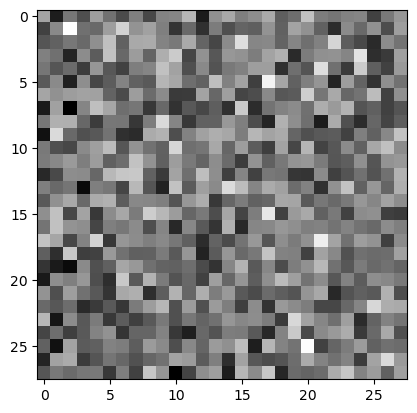

In [49]:
temp_model = FMNIST_model(printtoggle=True)
rand_img = torch.randn(1, 1, 28, 28)
plt.imshow(rand_img[0,:,:,:].permute(1,2,0), cmap='gray')

temp_output = temp_model(rand_img)
print(temp_output[0])

## Model creation function

In [38]:
def create_model(conv_layer_units = [16, 32, 64]):
    model = FMNIST_model(conv_layer_units, printtoggle=False)
    lossfun = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-04)

    return model, lossfun, optimizer

In [39]:
print(create_model())

(FMNIST_model(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
), CrossEntropyLoss(), Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
))


In [45]:
X, y = next(iter(train_loader))
print(X.shape)

torch.Size([32, 1, 28, 28])


## Model training function

In [54]:
num_epochs = 20

def train_model():
    # use previously initiated model
    train_losses = []
    train_acc    = []
    dev_losses   = []
    dev_acc      = []

    for i in range(num_epochs):
        print(f"Epoch {i+1}/{num_epochs}")
        model.train()

        batch_loss = []
        batch_acc  = []

        for batch, labels in train_loader:
            yHat_batch = model(batch)[0]
            loss = lossfun(yHat_batch, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss.append(loss.item())
            batch_pred = torch.argmax(yHat_batch, axis=1)
            batch_acc.append(
                100*torch.mean(
                    (batch_pred == labels).float().detach()
                )
            )
            
        # end of batches
        train_losses.append(np.mean(batch_loss))
        train_acc.append(np.mean(batch_acc))
        
        model.eval()
        X_dev, y_dev = next(iter(dev_loader))
        yHat_dev = model(X_dev)[0]
        dev_loss = lossfun(yHat_dev, y_dev)
        dev_pred = torch.argmax(yHat_dev, axis=1)

        dev_losses.append(dev_loss.item())
        dev_acc.append(
            100*torch.mean(
                (dev_pred == y_dev).float().detach()
            )
        )

    # end of epochs
    return train_losses, dev_losses, train_acc, dev_acc, model

## Train a model and plot losses and accuracies

Epoch 1/2
Epoch 2/2


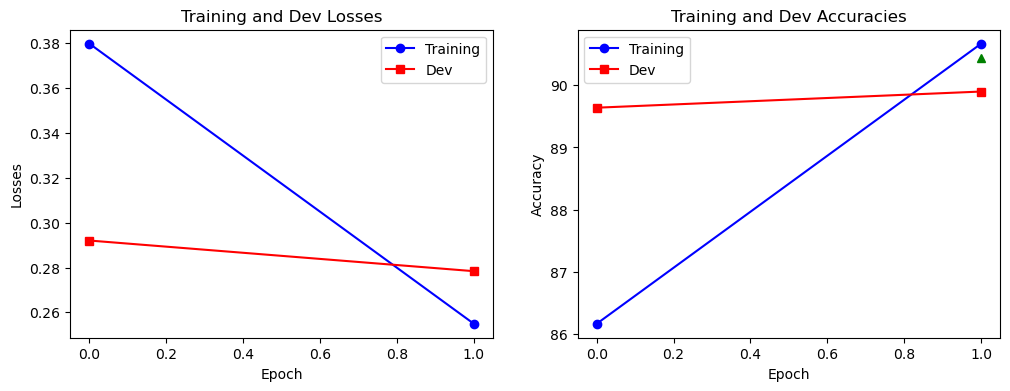

In [56]:
# test with 2 epochs
num_epochs = 2
model, lossfun, optimizer = create_model()
train_losses, dev_losses, train_acc, dev_acc, model = train_model()
plt.figure(figsize=[12,4])

plt.subplot(121)
plt.plot(range(num_epochs), train_losses, "bo-")
plt.plot(range(num_epochs), dev_losses, "rs-")
plt.xlabel("Epoch")
plt.ylabel("Losses")
plt.title("Training and Dev Losses")
plt.legend(["Training", "Dev"])

plt.subplot(122)
# get test accuracy
X_test, y_test = next(iter(test_loader))
yHat_test = model(X_test)[0]
test_pred = torch.argmax(yHat_test, axis=1)
test_acc = 100*torch.mean(
    (test_pred == y_test).float().detach()
)
plt.plot(range(num_epochs), train_acc, "bo-")
plt.plot(range(num_epochs), dev_acc, "rs-")
plt.plot(num_epochs-1, test_acc, "g^")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Dev Accuracies")
plt.legend(["Training", "Dev"])


Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


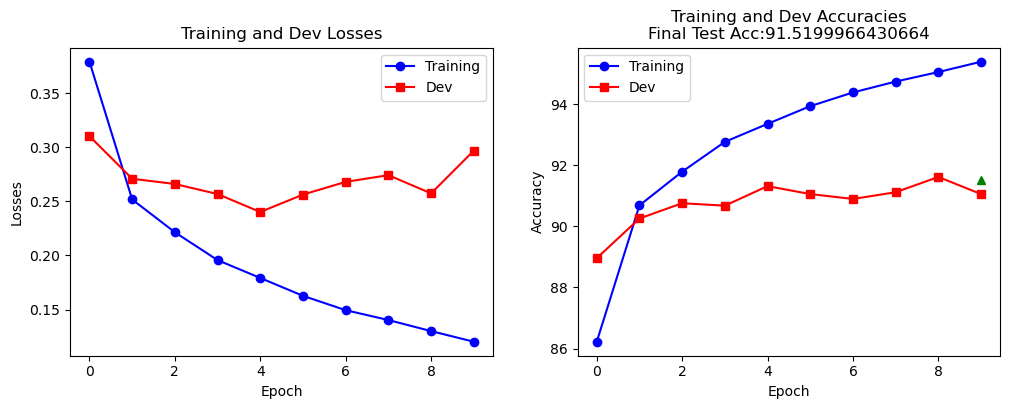

In [58]:
# real training
num_epochs = 10
model, lossfun, optimizer = create_model()
train_losses, dev_losses, train_acc, dev_acc, model = train_model()
plt.figure(figsize=[12,4])

plt.subplot(121)
plt.plot(range(num_epochs), train_losses, "bo-")
plt.plot(range(num_epochs), dev_losses, "rs-")
plt.xlabel("Epoch")
plt.ylabel("Losses")
plt.title("Training and Dev Losses")
plt.legend(["Training", "Dev"])

plt.subplot(122)
# get test accuracy
X_test, y_test = next(iter(test_loader))
yHat_test = model(X_test)[0]
test_pred = torch.argmax(yHat_test, axis=1)
test_acc = 100*torch.mean(
    (test_pred == y_test).float().detach()
)
plt.plot(range(num_epochs), train_acc, "bo-")
plt.plot(range(num_epochs), dev_acc, "rs-")
plt.plot(num_epochs-1, test_acc, "g^")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"Training and Dev Accuracies\nFinal Test Acc:{test_acc}")
plt.legend(["Training", "Dev"])
